In [1]:
# %load_ext autoreload
# %autoreload 2
import pandas as pd
import numpy as np
from matplotlib.pylab import plt
import seaborn as sns
sns.set_style("darkgrid")

from utils import data_util, exp_util

In [2]:
## LOAD DATA
df = pd.read_json('data/data.jsonl')
print(f"{len(df)} articles loaded.")	

df.head()

10000 articles loaded.


,author,title,description,url,source,image,category,language,country,published_at
0,Aiyana Moya,How Santa Cruz Cities are Approaching Outdated...,The process of changing the gendered pronouns ...,https://www.goodtimes.sc/how-santa-cruz-cities...,gtweekly,None,general,en,us,2023-03-01 00:00:00+00:00
1,Catholic Online,"St. David: Saint of the Day for Wednesday, Mar...","According to tradition, St. David was the son ...",https://www.catholic.org/saints/sofd.php?month...,Catholic,None,general,en,us,2023-03-01 00:00:00+00:00
2,Cameron Scheetz,WATCH: Kids react to drag with open arms and o...,The video is a heartwarming reminder that the ...,https://www.queerty.com/watch-kids-react-to-dr...,queerty,None,general,en,us,2023-03-01 00:00:00+00:00
3,None,Khởi nghiệp để không còn chuyện “giải cứu” tha...,"Sinh ra và lớn lên ở Bình Thuận, chứng kiến cả...",https://thanhnien.vn/khoi-nghiep-de-khong-con-...,thanhniennews,None,general,en,us,2023-03-01 00:00:00+00:00
4,None,Pink + pink = gold? Hybrid hummingbird's feath...,"The pink-throated brilliant hummingbird, Helio...",https://phys.org/news/2023-02-pink-gold-hybrid...,physorg,https://scx1.b-cdn.net/csz/news/tmb/2023/pink-...,general,en,us,2023-03-01 00:00:01+00:00


In [3]:
## CLEAN DATA
# 1. Normalize
df['title'] = df["title"].map(data_util.normalize_text)
df['description'] = df["description"].map(data_util.normalize_text)

# 2. Filter out vietnamese and drop duplicates
df = df[~df["url"].str.contains("thanhnien")][["title", "description"]]
df.drop_duplicates(subset='title', inplace=True, keep='first')
df.drop_duplicates(subset='description', inplace=True, keep='first')
print(f"{len(df)} articles remaining after dropping duplicates and Vietnamese")	

9038 articles remaining after dropping duplicates and Vietnamese


In [4]:
## TOKENIZE
tokenizer = exp_util.get_tokenizer()

df['title_tokens'] = df["title"].map(tokenizer.tokenize)
df['description_tokens'] = df["description"].map(tokenizer.tokenize)
df.head()

,title,description,title_tokens,description_tokens
0,How Santa Cruz Cities are Approaching Outdated...,The process of changing the gendered pronouns ...,"[How, ĠSanta, ĠCruz, ĠCities, Ġare, ĠAppro, ac...","[The, Ġprocess, Ġof, Ġchanging, Ġthe, Ġg, ende..."
1,"St. David: Saint of the Day for Wednesday, Mar...","According to tradition, St. David was the son ...","[St, ., ĠDavid, :, ĠSaint, Ġof, Ġthe, ĠDay, Ġf...","[According, Ġto, Ġtradition, ,, ĠSt, ., ĠDavid..."
2,WATCH: Kids react to drag with open arms and o...,The video is a heartwarming reminder that the ...,"[WATCH, :, ĠKids, Ġreact, Ġto, Ġdrag, Ġwith, Ġ...","[The, Ġvideo, Ġis, Ġa, Ġheart, warming, Ġremin..."
4,Pink + pink = gold? Hybrid hummingbird's feath...,"The pink-throated brilliant hummingbird, Helio...","[Pink, Ġ+, Ġpink, Ġ=, Ġgold, ?, ĠHybrid, Ġhumm...","[The, Ġpink, -, thro, ated, Ġbrilliant, Ġhummi..."
5,'Poverty is a policy choice': Millions of Amer...,"As of Wednesday, around 30 million people acro...","[', P, overty, Ġis, Ġa, Ġpolicy, Ġchoice, ':, ...","[As, Ġof, ĠWednesday, ,, Ġaround, Ġ30, Ġmillio..."


In [5]:
## FILTER DATA
# Remove rows with empty title or desc.  OR titles that are longer than the desc. (contradicts assumption we are making about the data)

title_lengths = df.title_tokens.map(len)
desc_lengths = df.description_tokens.map(len)

invalid_samples = (title_lengths == 0) | (title_lengths >= desc_lengths)
print(f"{sum(invalid_samples)} invalid samples.")

df_filtered = df[~invalid_samples]

2497 invalid samples.


In [7]:
def print_stats(name, seq_lengths):
	print(f"  {name} len.")
	print(f'\tMin: {min(seq_lengths)}\t\tMax: {max(seq_lengths)}')
	print(f'\tMedian: {np.median(seq_lengths)}\tMean: {int(np.mean(seq_lengths))}\tStddev: {int(np.std(seq_lengths))}')

title_lengths_filt = df_filtered.title_tokens.map(len)
desc_lengths_filt = df_filtered.description_tokens.map(len)
print("SEQUENCE LENGTH STATS. (after filtering invalid samples):")
print_stats("Title", title_lengths_filt)
print_stats("Desc.", desc_lengths_filt)
print_stats("Total", title_lengths_filt +desc_lengths_filt)

SEQUENCE LENGTH STATS. (after filtering invalid samples):
  Title len.
	Min: 4		Max: 83
	Median: 17.0	Mean: 18	Stddev: 7
  Desc. len.
	Min: 9		Max: 194
	Median: 78.0	Mean: 71	Stddev: 28
  Total len.
	Min: 17		Max: 207
	Median: 97.0	Mean: 90	Stddev: 31


In [9]:
## FILTER OUTLIERS 
# Remove samples with title or desc. length > 3*stddev from mean 

for col in ['title_tokens', 'description_tokens']:
	lengths = df[col].map(len)
	mu, std = np.mean(lengths), np.std(lengths)
	df_filtered = df_filtered[lengths.between(mu - 3*std, mu + 3*std)]

df_filtered.reset_index(inplace=True, drop=True)
print(f"{len(df_filtered)} samples remaining after removing outliers")

6461 samples remaining after removing outliers


/var/folders/gn/wndrm52n61s3sc5h9q0hgjm40000gn/T/ipykernel_25979/1951663476.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered = df_filtered[lengths.between(mu - 3*std, mu + 3*std)]


## Visualizations

<p> The plot below demonstrates that the original dataset does not follow a normal gaussian distribution, and instead indicates that there are two different cluster types, as represented by the 2 curves in the histogram. </p>

By removing invalid samples--i.e. when the title is *not* shorter than the description-- we are able to adjust the dataset such that it follows a more normal distribution. 

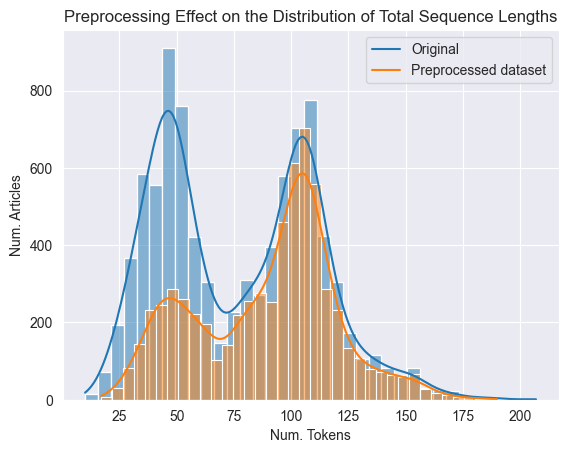

In [64]:
og_total = df['description_tokens'].map(len) + df['title_tokens'].map(len)
filt_total = df_filtered['description_tokens'].map(len) + df_filtered['title_tokens'].map(len)

sns.histplot(data=og_total, kde=True)
sns.histplot(data=filt_total, kde=True)

plt.title("Preprocessing Effect on the Distribution of Total Sequence Lengths")
plt.xlabel("Num. Tokens")
plt.ylabel("Num. Articles")
plt.legend(labels=["Original","Preprocessed dataset"])

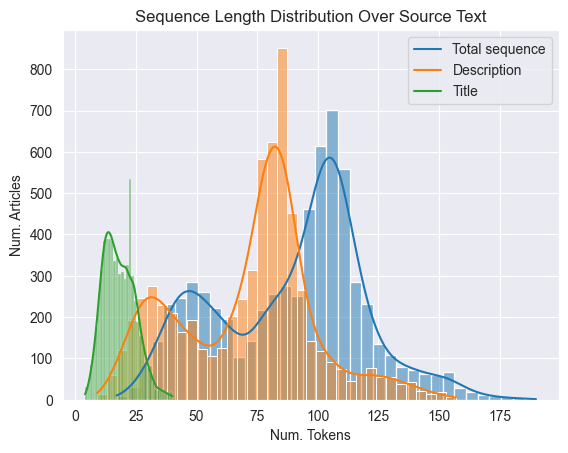

In [65]:
sns.histplot(data = filt_total,kde=True)
sns.histplot(data = df_filtered['description_tokens'].map(len), kde=True)
sns.histplot(data = df_filtered['title_tokens'].map(len), kde=True)

plt.title(str.title("Sequence length distribution over source text"))
plt.xlabel("Num. Tokens")
plt.ylabel("Num. Articles")
plt.legend(labels=["Total sequence", "Description", 'Title'])
